In [ ]:
# from google.colab import drive
# # mount drive
# drive.mount('/content/drive')
# data_path = 'drive/My Drive/02_these_mp_recognition/'
# #data_path = 'drive/My Drive/Colab Notebooks/These/08_noise_corr_func/'

# # update path to import module from drive
# import sys
# sys.path.append('/content/drive/My Drive/04_these_ssl/')
# print(sys.path)

# #from test_module import test_func
# #test_func()

Mounted at /content/drive
['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/04_these_ssl/']


### Dataset
https://github.com/yangminz/Semi-supervised_Embedding/blob/master/src/utils/data_util.py


Links
Custom loss:
- https://cs230.stanford.edu/blog/pytorch/
- https://discuss.pytorch.org/t/custom-loss-functions/29387/2
- https://pytorch.org/docs/master/nn.html#loss-functions
- https://habr.com/en/company/ods/blog/424781/
- https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
- https://stackoverflow.com/questions/44597523/custom-loss-function-in-pytorch

Debug
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795/3
- https://stackoverflow.com/questions/48274929/pytorch-runtimeerror-trying-to-backward-through-the-graph-a-second-time-but
- https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time-while-using-custom-loss-function/12360
- https://discuss.pytorch.org/t/loss-backward-raises-error-grad-can-be-implicitly-created-only-for-scalar-outputs/12152


MSEloss
- https://stackoverflow.com/questions/48219272/where-can-i-see-the-source-code-for-pytorchs-mseloss

Pytorch
- Permute axis torch: https://stackoverflow.com/questions/44841654/no-n-dimensional-tranpose-in-pytorch
- bin model: https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89


In [1]:
import numpy as np
import pandas as pd
# from data_generator_sx3 import SX3Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm

from utils import load_ds_data

import random
random.seed(2020)

In [2]:
NUMITERMAX = 100
METHOD = 'emd'
NSUP = 4
NTOTAL = 600
NB_RUNS = 5
BATCH_SIZE = 128
DISCR = 80

data_path = ''

In [3]:
#%% prepare data generator data
Xtrain, Xval, ytrain, yval = load_ds_data(DISCR, data_path, nb_samples=NTOTAL, test_size=0.1)
Xtrain.shape, Xval.shape

((540, 80, 80, 2), (60, 80, 80, 2))

In [4]:
# # gps dataset
# #%% prepare sx3 dataset
# dataset_nomp = SX3Dataset(label=0, global_path=data_path + 'sx_data/snap_no_mp_SX3_5_sat_11_89x81')
# dataset_mp = SX3Dataset(label=1, global_path=data_path + 'sx_data/snap_mp_SX3_5_sat_11_89x81')
# data_nomp = dataset_nomp.build(discr_shape=(20,20), nb_samples=100) # 100
# data_mp = dataset_mp.build(discr_shape=(20,20), nb_samples=100) # 100

# data_val = np.concatenate((data_mp, data_nomp), axis=0)
# np.random.shuffle(data_val)

# X_val = np.array([x['table'] for x in data_val])
# X_mp = np.array([x['table'] for x in data_mp])
# X_nomp = np.array([x['table'] for x in data_nomp])
# y_val = np.array([x['label'] for x in data_val])[...,None]
# X_val.shape

In [5]:
# Xtrain, Xval, ytrain, yval = train_test_split(X_val, y_val, shuffle=True, test_size=0.15)
# Xtrain.shape, ytrain.shape, Xval.shape, yval.shape

### Dataset/ DataLoader

In [6]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
torch.__version__

'1.5.1'

In [8]:
# introduce indices in dataset
indices_train = np.arange(0,Xtrain.shape[0])
indices_val = np.arange(0,Xval.shape[0])

Xtrain_tensor = torch.tensor(Xtrain)
ytrain_tensor = torch.tensor(ytrain)
Xtrain_tensor = Xtrain_tensor.permute(0, 3, 1, 2)
indices_tensor = torch.tensor(np.arange(0,Xtrain.shape[0]))
train_tensor = TensorDataset(Xtrain_tensor, ytrain_tensor, indices_tensor)

Xval_tensor = torch.tensor(Xval)
yval_tensor = torch.tensor(yval)
Xval_tensor = Xval_tensor.permute(0, 3, 1, 2)
indices_val_tensor = torch.tensor(np.arange(0,Xval.shape[0]))
val_tensor = TensorDataset(Xval_tensor, yval_tensor, indices_val_tensor)

# train_sampler = SubsetRandomSampler(indices)
train_loader = DataLoader(train_tensor, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=BATCH_SIZE, shuffle=False)

loader type:  <class 'list'>
matrix:  torch.Size([128, 2, 80, 80])
labels:  torch.Size([128]) tensor([0, 0, 0, 0, 0])
indices:  torch.Size([128]) tensor([473, 426, 432, 196, 280])


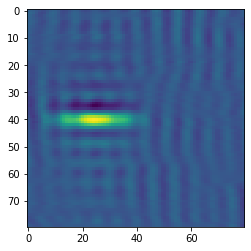

In [9]:
print('loader type: ', type(next(iter(train_loader))))
print('matrix: ', next(iter(train_loader))[0].shape)
print('labels: ', next(iter(train_loader))[1].shape, next(iter(train_loader))[1][:5])
print('indices: ', next(iter(train_loader))[2].shape, next(iter(train_loader))[2][:5])

batch = next(iter(train_loader))
#batch[0].reshape(-1, 20, 20, 2)

plt.imshow(batch[0][0,0,...])

### Standard model Pytorch

In [10]:
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torchvision import datasets, models, transforms
import torch.optim as optim
import os

In [11]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.lin = nn.Linear(32 * 38 * 38, 256)
#     self.lin = nn.Linear(32 * 8 * 8, 256)
    self.out = nn.Linear(256, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
#     print(x.shape) # shape [4, 16, 3, 3]

    x = x.view(x.size(0), -1)
    x = F.relu(self.lin(x))
    out  = self.out(x)

    return out

In [ ]:
def plot_conv_curves_bench(losses, val_losses, accs, val_accs):
  plt.plot(losses, label="loss")
  plt.plot(val_losses, label="val loss")
  plt.grid()
  plt.xlabel("epoch")
  plt.ylabel("BCELoss")
  plt.legend()
  plt.show()

  accs = np.where(np.array(accs) < 1, accs, 1)

  plt.plot(accs, label="acc")
  plt.plot(val_accs, label="val acc")
  plt.grid()
  plt.xlabel("epoch")
  plt.ylabel("acc")
  plt.legend()
  plt.show()

def plot_conv_curves(lambd_loss, losses, val_losses, accs, val_accs):
  plt.plot(bench_losses, label="loss benchmark")
  plt.plot(losses, label="custom loss")
  plt.plot(bench_val_losses, label="val loss benchmark")
  plt.plot(val_losses, label="val custom loss")
  plt.title('lambda: {}'.format(lambd_loss))
  plt.grid()
  plt.xlabel("epoch")
  plt.ylabel("BCELoss")
  plt.legend()
  plt.show()

  accs = np.where(np.array(accs) < 1, accs, 1)

  plt.plot(bench_accs, label="acc benchmark")
  plt.plot(accs, label="custom acc")
  plt.plot(bench_val_accs, label="val acc benchmark")
  plt.plot(val_accs, label="val custom acc")
  plt.title('lambda: {}'.format(lambd_loss))
  plt.grid()
  plt.xlabel("epoch")
  plt.ylabel("acc")
  plt.legend()
  plt.show()

In [123]:
def train_val(model, lambd_loss=0, ssl=False):
  losses = []
  val_losses = []
  accs = []
  val_accs = []

  for epoch in tqdm(range(epochs)):
    
    running_train_loss = 0
    running_train_corrects = 0
    # train phase
    model.train()
    for i, batch in enumerate(loaders['train']):
      optimizer.zero_grad()

      if ssl:
        # recompute distsi for batch
        dists = torch.tensor(batchWD(batch[0])).to(device)
        output = model(batch[0].float().to(device))
        preds = torch.round(torch.sigmoid(output))
        loss = sslLoss(output, batch[1].to(device), dists, lambd=lambd_loss)
      else:
        output = model(batch[0].float().to(device))
        preds = torch.round(torch.sigmoid(output))
        loss = criterion(output, batch[1].float().reshape(-1, 1).to(device))
      
      loss.backward()
      optimizer.step()
      
      running_train_loss += loss.item()
      
      # compute acc only for labeled images in each batch. get ids of only yval sup
      sup_batch = batch[1].data.cpu()
      sup_preds = preds.data.cpu()
#       print('check shape batch: ', sup_batch.shape, sup_preds.shape)
#       print('check shape sup batch: ', sup_batch.shape, sup_preds.shape)
#       print(sup_preds.squeeze(), sup_batch.squeeze())
#       print('sum: ', torch.sum(sup_preds.squeeze() == sup_batch.squeeze()).float())
#       print('shape: ', batch[1].shape)
#       print('check div: ', torch.sum(sup_preds.squeeze() == sup_batch.squeeze()).float() / batch[1].shape[0])
      running_train_corrects += torch.sum(sup_preds.squeeze() == sup_batch.squeeze()).float() / batch[1].shape[0]
#       break
#     break

    nb_batches = i + 1
    losses.append(running_train_loss/nb_batches)
    accs.append(running_train_corrects/nb_batches)

    running_val_loss = 0
    running_val_corrects = 0
    # val phase
    model.eval()
    for i, batch in enumerate(loaders['val']):
      output = model(batch[0].float().to(device))
      preds = torch.round(torch.sigmoid(output))

      loss = criterion(output, batch[1].float().reshape(-1, 1).to(device))

      running_val_loss += loss.item()

      # compute acc only for labeled images in each batch. get ids of only yval sup
      sup_batch = batch[1].data.cpu()
      sup_preds = preds.data.cpu()
      running_val_corrects += torch.sum(sup_preds.squeeze() == sup_batch.squeeze()).float() / batch[1].shape[0]

    nb_val_batches = i + 1
    val_losses.append(running_val_loss/ nb_val_batches)
    val_accs.append(running_val_corrects/ nb_val_batches)

    print("-----------------Epoch: {}".format(epoch))
    print(preds.squeeze()[:15], batch[1].squeeze()[:15])
    print('Train Loss: {}'.format(round(running_train_loss/nb_batches, 5)))
    print('Train Acc: {}'.format(round(float(running_train_corrects)/nb_batches, 5)))
    print('Val Loss: {}'.format(round(running_val_loss/nb_val_batches, 5)))
    print('Val Acc: {}'.format(round(float(running_val_corrects)/nb_val_batches, 5)))

  return model, losses, val_losses, accs, val_accs

In [124]:
a = torch.tensor([0,1,0,1,0,1,0])
b = torch.tensor([1,1,1,1,1,1,1])
a.shape, torch.sum(a == b).float() / a.shape[0]

(torch.Size([7]), tensor(0.4286))

In [125]:
torch.tensor(67).float() / 128, torch.tensor(67) / 128

(tensor(0.5234), tensor(0))

### Train on supervised loss

-----------------Epoch: 0
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<SliceBackward>) tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])
Train Loss: 0.90581
Train Acc: 0.52545
Val Loss: 0.80713
Val Acc: 0.5
-----------------Epoch: 1
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
       grad_fn=<SliceBackward>) tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])
Train Loss: 0.72811
Train Acc: 0.48326
Val Loss: 0.66499
Val Acc: 0.91667
-----------------Epoch: 2
tensor([1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
       grad_fn=<SliceBackward>) tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])
Train Loss: 0.65287
Train Acc: 0.86875
Val Loss: 0.61714
Val Acc: 0.93333
-----------------Epoch: 3
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       grad_fn=<SliceBackward>) tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])
Train Loss: 0.57903
Train Acc: 0.90022
Val Loss: 0.55602
V

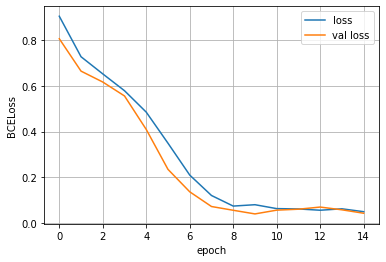

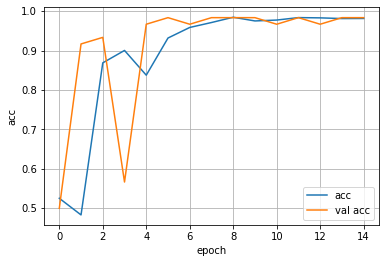

In [126]:
# define device
# device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device = 'cpu'

# check layers shapes
model = Model().to(device)

loaders = {"train": train_loader, "val": val_loader}

lr = 1e-3
epochs = 15
THR = 0.5

optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

model, losses, val_losses, accs, val_accs = train_val(model)
bench_losses, bench_val_losses = losses, val_losses
bench_accs, bench_val_accs = accs, val_accs
plot_conv_curves_bench(losses, val_losses, accs, val_accs)

### Custom Loss Pytorch

#### Compute WD

In [ ]:
!pip install pot

     |████████████████████████████████| 430kB 4.0MB/s 


In [ ]:
batch = next(iter(train_loader))

In [ ]:
NUMITERMAX = 100
METHOD = 'emd'

In [ ]:
import ot
from tqdm.notebook import tqdm
import itertools

# copmute wass distance for batch of 4 imgs
def funcWD(inpimg1, inpimg2, lambd = 1e5):

  img1 = inpimg1[0,5:15,:15]
  img2 = inpimg2[0,5:15,:15]

  #img1 = inpimg1
  #img2 = inpimg2
  #print(img1.shape)

  img1 = (img1 + abs(img1.min()))
  img1 /= img1.sum()
  img2 = (img2 + abs(img2.min()))
  img2 /= img2.sum()

  n = img1.flatten().shape[0]
  x = np.arange(n, dtype=np.float64)

  # loss matrix
  matr = ot.dist(x.reshape(n,1), x.reshape(n,1))
  matr /= matr.max()

  if METHOD == "sinkhorn": 
    # solve sinkhorn. entropic regularized OT
    coupling = ot.sinkhorn(img1.flatten(), img2.flatten(), matr, lambd)
    wdist = ot.sinkhorn2(img1.flatten(), img2.flatten(), matr, lambd)
  elif METHOD == "emd":
    # solve EMD. exact linear program
    coupling = ot.emd(img1.flatten(), img2.flatten(), matr, numItermax=NUMITERMAX)
    wdist = ot.emd2(img1.flatten(), img2.flatten(), matr, numItermax=NUMITERMAX)
  else:
    raise ValueError("Bad method argument: ", method)

  del img1, img2

  return wdist, coupling, matr


def batchWD(xbatch, lambd_wd=0.1):
  dists = np.zeros(shape=(xbatch.shape[0], xbatch.shape[0]))
  for i in range(xbatch.shape[0]):
    for j in range(xbatch.shape[0]):
      wdist, coupling, matr = funcWD(xbatch[i], xbatch[j], lambd=lambd_wd)
      dists[i,j] = wdist
  return dists

In [ ]:
%%time
print(next(iter(train_loader))[0].shape)
batchWD(next(iter(train_loader))[0])

torch.Size([16, 2, 20, 20])


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


CPU times: user 1.19 s, sys: 54.4 ms, total: 1.25 s
Wall time: 1.35 s


#### Train on unsupervised loss

In [ ]:
# dummy MSE Loss
def lossFN(output, target, dists, lambd=1):
  loss = torch.mean((output - target)**2)
  return loss

def sslLoss(output, target, dists, lambd=1):

  sup_loss = criterion(output, target.float())
  ssl_loss = torch.zeros_like(target).to(device).type_as(sup_loss) #(((target - output) * target) ** 2)

  dists = dists.type_as(sup_loss)
  target = target.type_as(sup_loss)

  if lambd == 0:
    return sup_loss

  # compute binary outputs
  preds = torch.round(torch.sigmoid(output))
  for i in range(target.shape[0]):
    for j in range(target.shape[1]):
      ssl_loss[i] += lambd * dists[i,j] * (preds[i, 0] - target[j, 0]) ** 2

  #print(ssl_loss.shape) # torch.Size([batch_size])
  return (ssl_loss.float().mean() + sup_loss)

#### Analysis on regularization factor

------------------------- lambda: 0.1


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.72044
Train Acc: 0.50227
Val Loss: 0.69166
Val Acc: 0.55804
-----------------Epoch: 1
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69495
Train Acc: 0.51477
Val Loss: 0.69757
Val Acc: 0.42857
-----------------Epoch: 2
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69
Train Acc: 0.55682
Val Loss: 0.69804
Val Acc: 0.49554
-----------------Epoch: 3
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.683

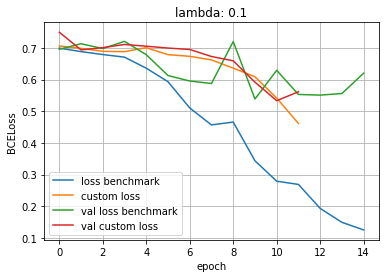

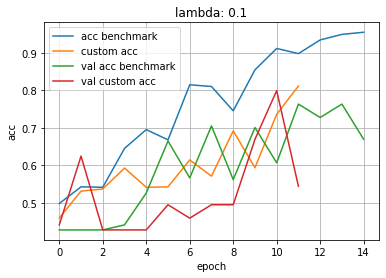

------------------------- lambda: 0.12


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.70008
Train Acc: 0.50341
Val Loss: 0.70872
Val Acc: 0.44196
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.6966
Train Acc: 0.51477
Val Loss: 0.70009
Val Acc: 0.44196
-----------------Epoch: 2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.70356
Train Acc: 0.50227
Val Loss: 0.69023
Val Acc: 0.55804
-----------------Epoch: 3
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.7

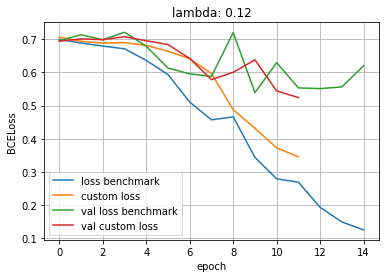

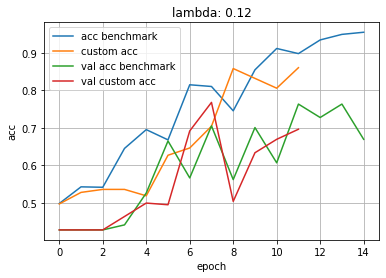

------------------------- lambda: 0.14


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.72197
Train Acc: 0.45909
Val Loss: 0.69205
Val Acc: 0.55804
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69552
Train Acc: 0.45795
Val Loss: 0.69902
Val Acc: 0.44196
-----------------Epoch: 2
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.6901
Train Acc: 0.51477
Val Loss: 0.70426
Val Acc: 0.42857
-----------------Epoch: 3
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.6

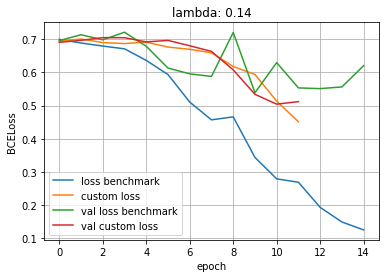

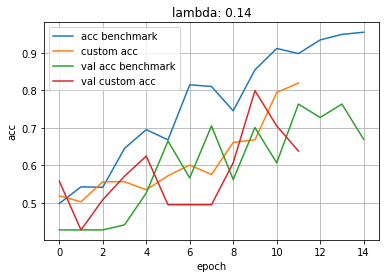

------------------------- lambda: 0.16


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.70894
Train Acc: 0.46591
Val Loss: 0.69219
Val Acc: 0.57143
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.71059
Train Acc: 0.45909
Val Loss: 0.6906
Val Acc: 0.60268
-----------------Epoch: 2
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69411
Train Acc: 0.52386
Val Loss: 0.71581
Val Acc: 0.44196
-----------------Epoch: 3
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.6

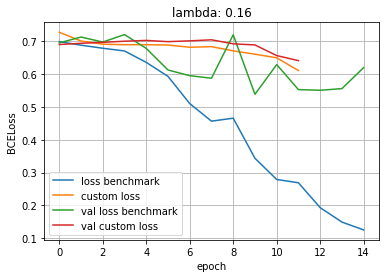

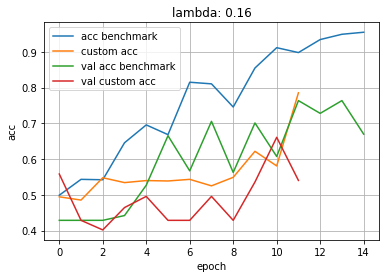

------------------------- lambda: 0.18


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69874
Train Acc: 0.48864
Val Loss: 0.69439
Val Acc: 0.44196
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69589
Train Acc: 0.49205
Val Loss: 0.71453
Val Acc: 0.44196
-----------------Epoch: 2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69323
Train Acc: 0.54432
Val Loss: 0.69139
Val Acc: 0.625
-----------------Epoch: 3
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69

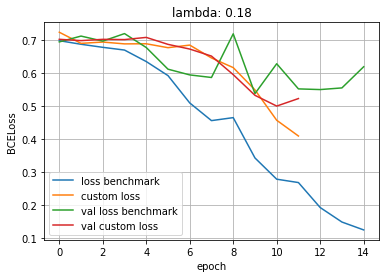

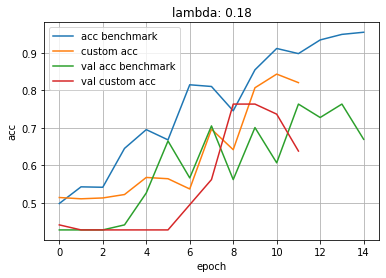

------------------------- lambda: 0.2


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69696
Train Acc: 0.51477
Val Loss: 0.68914
Val Acc: 0.55804
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69734
Train Acc: 0.49091
Val Loss: 0.69274
Val Acc: 0.44196
-----------------Epoch: 2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69514
Train Acc: 0.50568
Val Loss: 0.69168
Val Acc: 0.625
-----------------Epoch: 3
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69

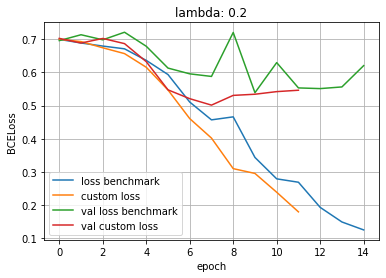

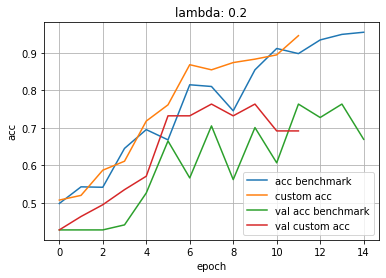

------------------------- lambda: 0.5


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.70288
Train Acc: 0.48864
Val Loss: 0.69675
Val Acc: 0.42857
-----------------Epoch: 1
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69911
Train Acc: 0.525
Val Loss: 0.71529
Val Acc: 0.44196
-----------------Epoch: 2
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.68692
Train Acc: 0.59545
Val Loss: 0.69598
Val Acc: 0.46429
-----------------Epoch: 3
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.68

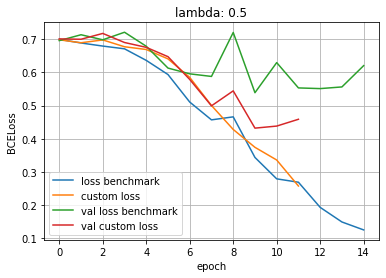

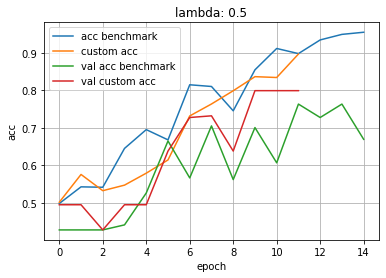

------------------------- lambda: 0.8


/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
/usr/local/lib/python3.6/dist-packages/ot/lp/__init__.py:421: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


-----------------Epoch: 0
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.70631
Train Acc: 0.51818
Val Loss: 0.69403
Val Acc: 0.42857
-----------------Epoch: 1
tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.69199
Train Acc: 0.54659
Val Loss: 0.69979
Val Acc: 0.53571
-----------------Epoch: 2
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.68822
Train Acc: 0.53409
Val Loss: 0.71654
Val Acc: 0.4375
-----------------Epoch: 3
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0', grad_fn=<SliceBackward>) tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])
Train Loss: 0.6

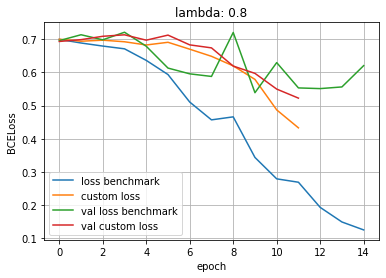

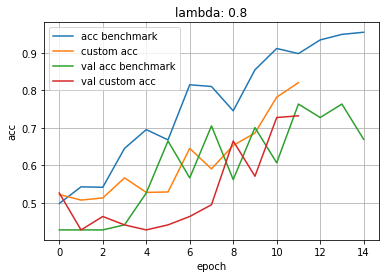


CPU times: user 1h 38min 9s, sys: 1min 45s, total: 1h 39min 54s
Wall time: 1h 45min 5s


In [ ]:
%%time

lambdas = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.5, 0.8]
nb_runs = 5

val_loss_df = pd.DataFrame(columns=['lambda_{}'.format(x) for x in lambdas])
val_acc_df = pd.DataFrame(columns=['lambda_{}'.format(x) for x in lambdas])

for lambd_loss in tqdm(lambdas):
  for i in tqdm(range(nb_runs)):
    model = Model().to(device)

    loaders = {"train": train_loader, "val": val_loader}

    lr = 1e-3
    epochs = 12
    THR = 0.5

    optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    print("------------------------- lambda: {}".format(lambd_loss))
    model, losses, val_losses, accs, val_accs = trainVal(model, lambd_loss=lambd_loss, ssl=True)
    
    val_loss_df.loc[i, 'lambda_{}'.format(lambd_loss)] = val_losses[-1]
    val_acc_df.loc[i, 'lambda_{}'.format(lambd_loss)] = val_accs[-1]
  plotConvCurves(lambd_loss, losses, val_losses, accs, val_accs)


In [ ]:
# make boxplot on metrics on last epoch
val_loss_df.to_csv('val_loss_df.csv')
val_loss_df

,lambda_0.1,lambda_0.12,lambda_0.14,lambda_0.16,lambda_0.18,lambda_0.2,lambda_0.5,lambda_0.8
0,0.506809,0.58807,0.493983,0.539929,0.441995,0.488014,0.527882,0.483842
1,0.431666,0.569558,0.500316,0.577199,0.490868,0.512593,0.504046,0.660709
2,0.62777,0.52467,0.677781,0.422409,0.472199,0.526002,0.519318,0.460628
3,0.60783,0.555905,0.619397,0.531698,0.520162,0.684346,0.450546,0.469379
4,0.561495,0.523985,0.511738,0.641282,0.523705,0.546061,0.458531,0.522286


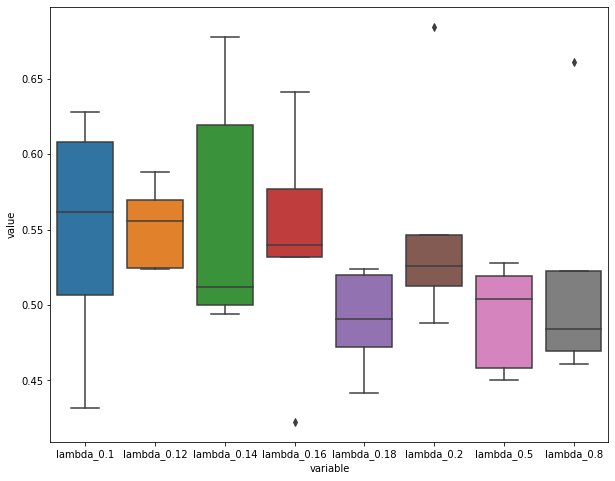

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.boxplot(x='variable', y='value', data=pd.melt(val_loss_df))

In [ ]:
val_acc_df = val_acc_df.astype(float)

In [ ]:
val_acc_df.to_csv('val_acc_df.csv')
val_acc_df

,lambda_0.1,lambda_0.12,lambda_0.14,lambda_0.16,lambda_0.18,lambda_0.2,lambda_0.5,lambda_0.8
0,0.767857,0.633929,0.799107,0.799107,0.767857,0.763393,0.669643,0.767857
1,0.732143,0.763393,0.799107,0.508929,0.799107,0.799107,0.799107,0.602679
2,0.660714,0.700893,0.566964,0.799107,0.799107,0.799107,0.732143,0.736607
3,0.700893,0.736607,0.473214,0.736607,0.767857,0.473214,0.696429,0.799107
4,0.544643,0.696429,0.638393,0.540179,0.638393,0.691964,0.799107,0.732143


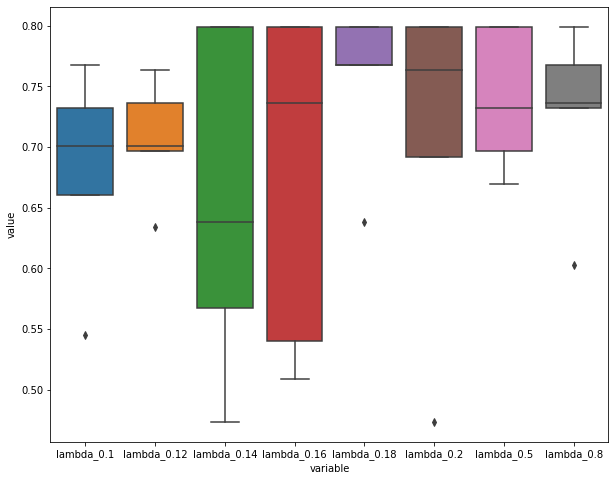

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='variable', y='value', data=pd.melt(val_acc_df))

In [ ]:
# save model
model_save_path = '/content/drive/My Drive/04_these_ssl/models/ssl_model_reg1e-1.pth'
torch.save(model.state_dict(),model_save_path)